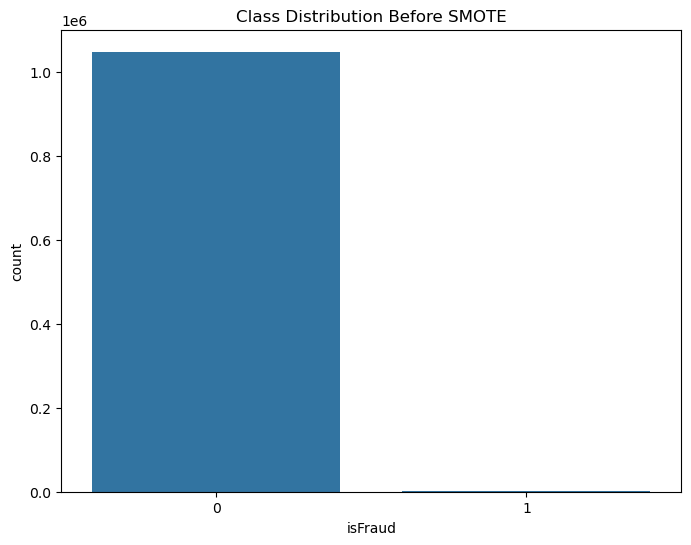

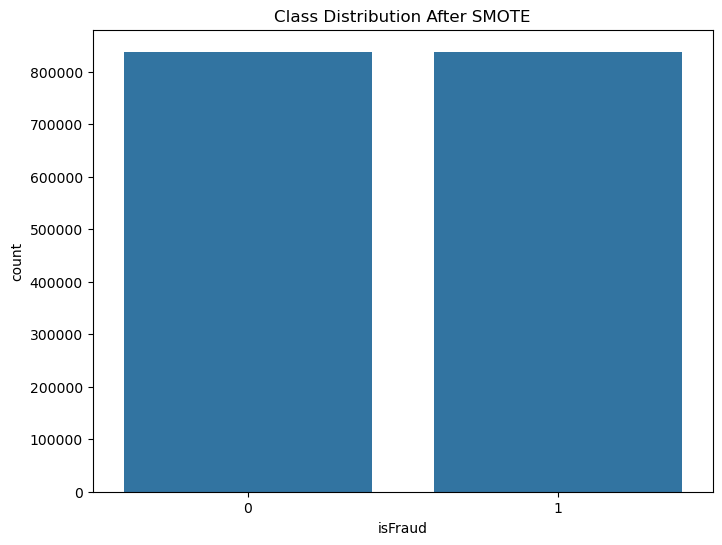

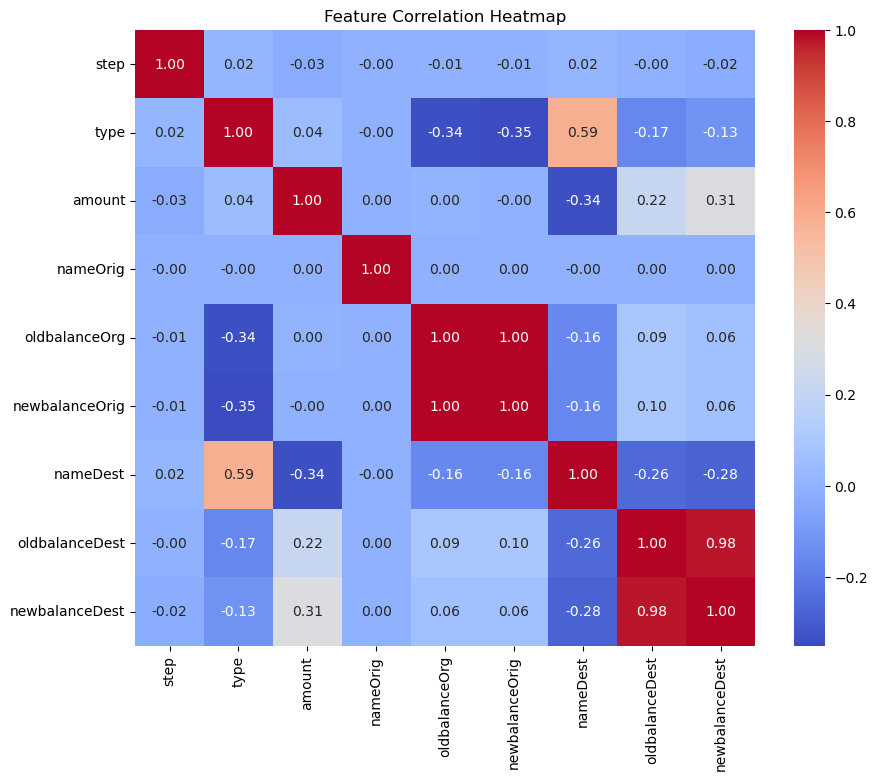

In [2]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load the actual CSV file
df = pd.read_csv("SFD_FD.csv")
df.dropna(how='all', inplace=True)  # Remove empty rows if any

# Preprocessing
le_type = LabelEncoder()
df['type'] = le_type.fit_transform(df['type'])
df['nameOrig'] = df['nameOrig'].astype('category').cat.codes
df['nameDest'] = df['nameDest'].astype('category').cat.codes

# Features and target
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title("Class Distribution Before SMOTE")
plt.show()

plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_smote)
plt.title("Class Distribution After SMOTE")
plt.show()

# Heatmap of feature correlations
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

Epoch 1/5


C:\Users\fahad.arshad\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2619/2619 ━━━━━━━━━━━━━━━━━━━━ 133s 51ms/step - loss: 0.2620 - val_loss: 0.0031
Epoch 2/5
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 119s 46ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 3/5
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 143s 55ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/5
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 149s 57ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 5/5
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 158s 60ms/step - loss: 0.0017 - val_loss: 0.0015


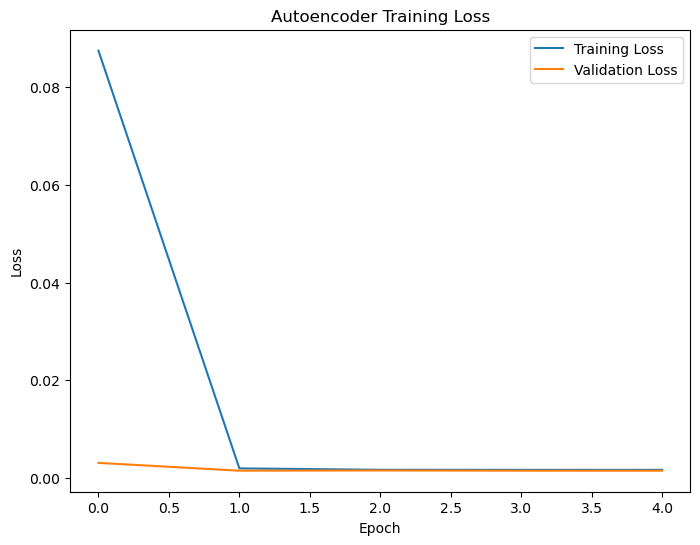

820/820 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
Autoencoder - Precision: 0.008517887563884156, Recall: 0.41284403669724773, F1: 0.01669139465875371


In [ ]:
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Train Autoencoder on full non-fraud data (no sampling)
non_fraud_data = X_train_scaled[y_train == 0]  # Use the exact non-fraud subset

autoencoder = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(X_train.shape[1], activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(non_fraud_data, non_fraud_data, epochs=5, batch_size=128, validation_split=0.2, verbose=1)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Detect anomalies
reconstructions = autoencoder.predict(X_test_scaled, batch_size=128)  # Use batch_size for prediction
mse = np.mean(np.square(X_test_scaled - reconstructions), axis=1)
threshold = np.percentile(mse[y_test == 0], 95)
y_pred_autoencoder = (mse > threshold).astype(int)

# Evaluate
autoencoder_precision = precision_score(y_test, y_pred_autoencoder)
autoencoder_recall = recall_score(y_test, y_pred_autoencoder)
autoencoder_f1 = f1_score(y_test, y_pred_autoencoder)
print(f"Autoencoder - Precision: {autoencoder_precision}, Recall: {autoencoder_recall}, F1: {autoencoder_f1}")

# Visualize reconstruction errors
plt.figure(figsize=(8, 6))
sns.histplot(mse[y_test == 0], color='blue', label='Non-Fraud', kde=True)
sns.histplot(mse[y_test == 1], color='red', label='Fraud', kde=True)
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Mean Squared Error")
plt.legend()
plt.show()

Isolation Forest - Precision: 0.006340579710144928, Recall: 0.06422018348623854, F1: 0.011541632316570486


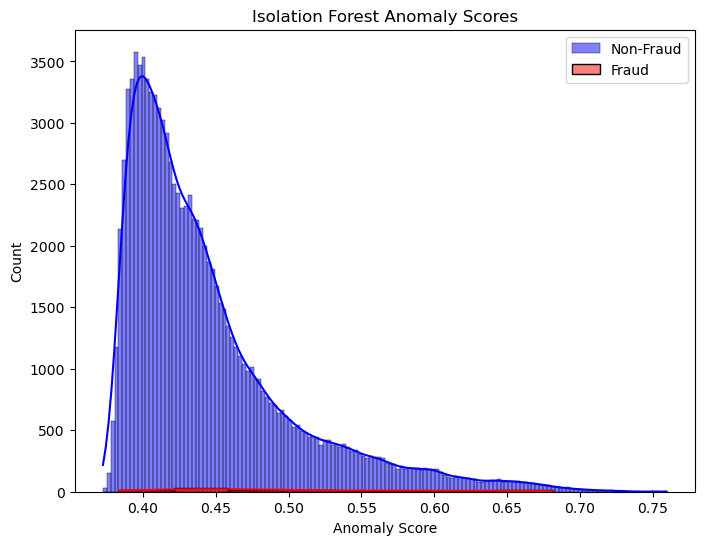

In [47]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_train_scaled)

# Predict anomalies
y_pred_iso = iso_forest.predict(X_test_scaled)
y_pred_iso = np.where(y_pred_iso == -1, 1, 0)

# Evaluate
iso_precision = precision_score(y_test, y_pred_iso)
iso_recall = recall_score(y_test, y_pred_iso)
iso_f1 = f1_score(y_test, y_pred_iso)
print(f"Isolation Forest - Precision: {iso_precision}, Recall: {iso_recall}, F1: {iso_f1}")

# Visualize anomaly scores
anomaly_scores = -iso_forest.score_samples(X_test_scaled)
plt.figure(figsize=(8, 6))
sns.histplot(anomaly_scores[y_test == 0], color='blue', label='Non-Fraud', kde=True)
sns.histplot(anomaly_scores[y_test == 1], color='red', label='Fraud', kde=True)
plt.title("Isolation Forest Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.legend()
plt.show()

Start Time: 21:21:15
Shape of df after sampling: (524288, 12)
Checking for NA values in df...
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
group             0
dtype: int64
Shape of df after dropping NA: (524288, 12)
Shape of X_train_smote: (837984, 10)
Time after SMOTE: 21:21:16, Duration: 0.02 minutes
NA values in train_df: 0
NA values in test_df: 0
Shape of train_df after dropna: (837984, 11)
Shape of test_df after dropna: (104858, 11)
Time after Training: 21:22:35, Duration: 1.33 minutes
Optimal Threshold: 0.520
Precision: 0.8842105263157894
Recall: 0.7706422018348624
F1 Score: 0.8235294117647058

Confusion Matrix for Group 0 (Unprivileged):
[[49274     6]
 [   10    41]]
Confusion Matrix for Group 1 (Privileged):
[[55464     5]
 [   15    43]]

False Positive Rate (Group 0): 0.00012175324675324675
False Positi

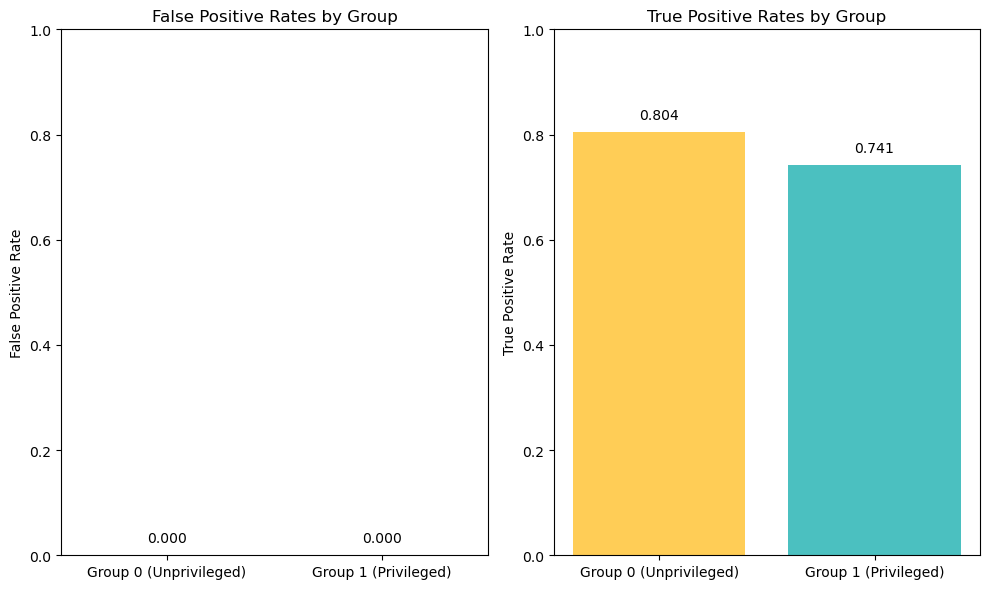

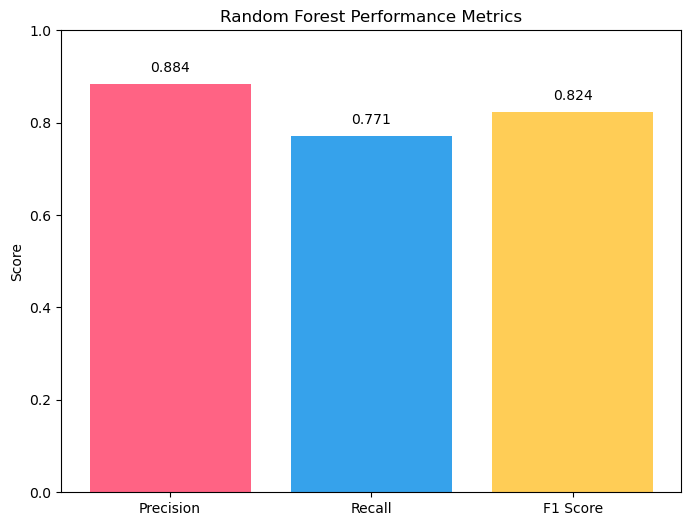

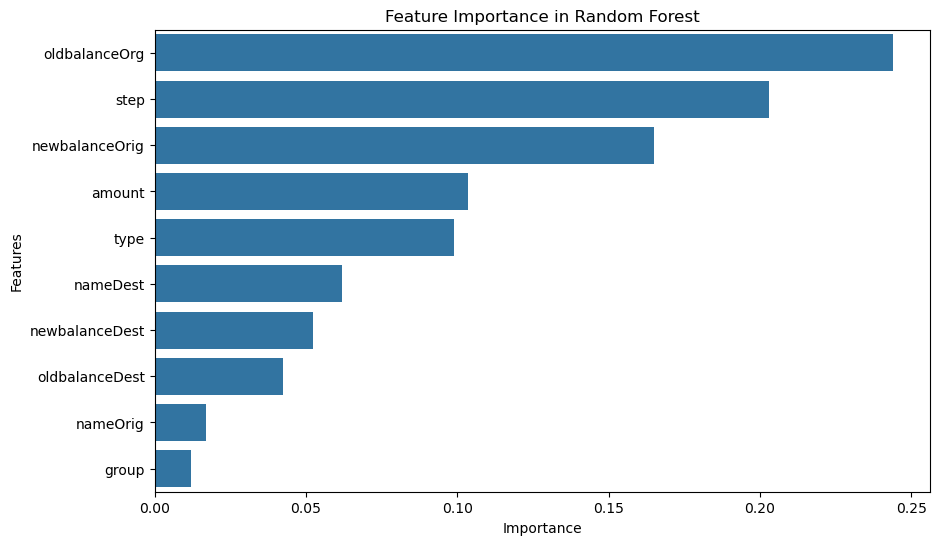

End Time: 21:22:36
Total Duration: 1.36 minutes


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Print start time
start_time = datetime.now()
print(f"Start Time: {start_time.strftime('%H:%M:%S')}")

# Assuming df is your DataFrame
# Sample the data if too large to speed up (adjust frac as needed)
df = df.sample(frac=0.5, random_state=42) if len(df) > 50000 else df
print("Shape of df after sampling:", df.shape)

# Check and handle NA values
print("Checking for NA values in df...")
print(df.isna().sum())
df = df.dropna()
print("Shape of df after dropping NA:", df.shape)

# Simulate a protected attribute
df['group'] = df['nameOrig'].apply(lambda x: 0 if str(x)[0] in ['0', '1', '2', '3', '4'] else 1)

# Prepare X and y
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE with fewer neighbors to speed up
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
print("Shape of X_train_smote:", X_train_smote.shape)

# Print time after SMOTE
smote_time = datetime.now()
print(f"Time after SMOTE: {smote_time.strftime('%H:%M:%S')}, Duration: {(smote_time - start_time).total_seconds() / 60:.2f} minutes")

# Create DataFrame for training and testing
train_df = pd.DataFrame(X_train_smote, columns=X_train.columns)
train_df['isFraud'] = y_train_smote
train_df['group'] = np.concatenate([
    df.loc[X_train.index, 'group'].reset_index(drop=True),
    np.random.choice([0, 1], size=len(X_train_smote) - len(X_train), p=[0.5, 0.5])
])

# Create test DataFrame and align indices
test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
test_df['isFraud'] = y_test.reset_index(drop=True)
test_df['group'] = df.loc[X_test.index, 'group'].reset_index(drop=True)

# Check for NA values and drop, ensuring indices are reset
print("NA values in train_df:", train_df.isna().sum().sum())
print("NA values in test_df:", test_df.isna().sum().sum())
train_df = train_df.dropna().reset_index(drop=True)
test_df = test_df.dropna().reset_index(drop=True)
print("Shape of train_df after dropna:", train_df.shape)
print("Shape of test_df after dropna:", test_df.shape)

# Sample weighting: Increase weight for unprivileged group
group_train = train_df['group']
weights = np.ones(len(train_df))
weights[group_train == 0] = 2.0
weights[group_train == 1] = 0.5

# Train a Random Forest model with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train_smote, y_train_smote, sample_weight=weights)

# Print time after training
train_time = datetime.now()
print(f"Time after Training: {train_time.strftime('%H:%M:%S')}, Duration: {(train_time - smote_time).total_seconds() / 60:.2f} minutes")

# Predict probabilities
y_pred_proba = rf.predict_proba(X_test_scaled)[:, 1]
y_pred_proba = pd.Series(y_pred_proba, index=test_df.index)

# Optimize threshold using precision-recall curve
precision, recall, thresholds = precision_recall_curve(test_df['isFraud'], y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.3f}")

# Apply group-specific thresholds to balance TPR
threshold_0 = optimal_threshold - 0.05
threshold_1 = optimal_threshold + 0.05
y_pred = pd.Series(index=test_df.index, dtype=int)
y_pred[test_df['group'] == 0] = (y_pred_proba[test_df['group'] == 0] >= threshold_0).astype(int)
y_pred[test_df['group'] == 1] = (y_pred_proba[test_df['group'] == 1] >= threshold_1).astype(int)

# Evaluate performance
precision = precision_score(test_df['isFraud'], y_pred)
recall = recall_score(test_df['isFraud'], y_pred)
f1 = f1_score(test_df['isFraud'], y_pred)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Confusion matrix for each group
group_0_idx = test_df['group'] == 0
group_1_idx = test_df['group'] == 1

cm_group_0 = confusion_matrix(test_df['isFraud'][group_0_idx], y_pred[group_0_idx])
cm_group_1 = confusion_matrix(test_df['isFraud'][group_1_idx], y_pred[group_1_idx])

print("\nConfusion Matrix for Group 0 (Unprivileged):")
print(cm_group_0)
print("Confusion Matrix for Group 1 (Privileged):")
print(cm_group_1)

# Calculate fairness metrics
def false_positive_rate(cm):
    tn, fp, fn, tp = cm.ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else 0

def true_positive_rate(cm):
    tn, fp, fn, tp = cm.ravel()
    return tp / (tp + fn) if (tp + fn) > 0 else 0

fpr_0 = false_positive_rate(cm_group_0)
fpr_1 = false_positive_rate(cm_group_1)
tpr_0 = true_positive_rate(cm_group_0)
tpr_1 = true_positive_rate(cm_group_1)

print(f"\nFalse Positive Rate (Group 0): {fpr_0}")
print(f"False Positive Rate (Group 1): {fpr_1}")
print(f"True Positive Rate (Group 0): {tpr_0}")
print(f"True Positive Rate (Group 1): {tpr_1}")
print(f"Equal Opportunity Difference (TPR Group 1 - TPR Group 0): {tpr_1 - tpr_0}")

# Visualization 1: Fairness Metrics (FPR and TPR by Group)
plt.figure(figsize=(10, 6))

# Subplot 1: False Positive Rates
plt.subplot(1, 2, 1)
plt.bar(['Group 0 (Unprivileged)', 'Group 1 (Privileged)'], [fpr_0, fpr_1], color=['#ff6384', '#36a2eb'])
plt.title('False Positive Rates by Group')
plt.ylabel('False Positive Rate')
plt.ylim(0, 1)
for i, v in enumerate([fpr_0, fpr_1]):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

# Subplot 2: True Positive Rates
plt.subplot(1, 2, 2)
plt.bar(['Group 0 (Unprivileged)', 'Group 1 (Privileged)'], [tpr_0, tpr_1], color=['#ffcd56', '#4bc0c0'])
plt.title('True Positive Rates by Group')
plt.ylabel('True Positive Rate')
plt.ylim(0, 1)
for i, v in enumerate([tpr_0, tpr_1]):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('fairness_metrics.png')
plt.show()

# Visualization 2: Performance Metrics (Precision, Recall, F1 Score)
plt.figure(figsize=(8, 6))
metrics = [precision, recall, f1]
metric_names = ['Precision', 'Recall', 'F1 Score']
plt.bar(metric_names, metrics, color=['#ff6384', '#36a2eb', '#ffcd56'])
plt.title('Random Forest Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
for i, v in enumerate(metrics):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')
plt.savefig('performance_metrics.png')
plt.show()

# Visualization 3: Feature Importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.savefig('feature_importance.png')
plt.show()

# Print end time
end_time = datetime.now()
print(f"End Time: {end_time.strftime('%H:%M:%S')}")
print(f"Total Duration: {(end_time - start_time).total_seconds() / 60:.2f} minutes")